# Medical X-Ray Data Processing

This notebook explores the VinBigData Chest X-ray dataset and prepares it for training a YOLOv8 model. We'll analyze the annotation structure, examine the distribution of different medical findings, and prepare the data for the YOLO format.

In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import yaml
import pydicom
from pathlib import Path
import random

plt.style.use('fivethirtyeight')
sns.set_context('notebook')

## Loading Annotations

The VinBigData Chest X-ray dataset provides annotations in CSV format with bounding boxes for 14 different thoracic findings:
- 0 - Aortic enlargement
- 1 - Atelectasis
- 2 - Calcification
- 3 - Cardiomegaly
- 4 - Consolidation
- 5 - ILD
- 6 - Infiltration
- 7 - Lung Opacity
- 8 - Nodule/Mass
- 9 - Other lesion
- 10 - Pleural effusion
- 11 - Pleural thickening
- 12 - Pneumothorax
- 13 - Pulmonary fibrosis


In [2]:
data_path = Path('../data/raw')
train_df = pd.read_csv(data_path / 'train.csv')
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN


## Dataset Structure Analysis

Let's examine the structure and size of the dataset to understand what we're working with.

In [3]:
print(f"Dataset shape: {train_df.shape}")
print(f"Number of unique images: {train_df['image_id'].nunique()}")

Dataset shape: (67914, 8)
Number of unique images: 15000


## Class Distribution

The dataset includes annotations for 14 different thoracic abnormalities, plus a "No finding" class. Understanding the distribution helps us identify potential class imbalance.

In [4]:
class_names = {
    0: 'Aortic enlargement',
    1: 'Atelectasis',
    2: 'Calcification',
    3: 'Cardiomegaly',
    4: 'Consolidation',
    5: 'ILD',
    6: 'Infiltration',
    7: 'Lung Opacity',
    8: 'Nodule/Mass',
    9: 'Other lesion',
    10: 'Pleural effusion',
    11: 'Pleural thickening',
    12: 'Pneumothorax',
    13: 'Pulmonary fibrosis',
    14: 'No finding'
}

class_distribution = train_df['class_id'].value_counts().sort_index()
named_distribution = pd.Series({class_names[k]: v for k, v in class_distribution.items()}, 
                              name='count')
named_distribution

Aortic enlargement     7162
Atelectasis             279
Calcification           960
Cardiomegaly           5427
Consolidation           556
ILD                    1000
Infiltration           1247
Lung Opacity           2483
Nodule/Mass            2580
Other lesion           2203
Pleural effusion       2476
Pleural thickening     4842
Pneumothorax            226
Pulmonary fibrosis     4655
No finding            31818
Name: count, dtype: int64

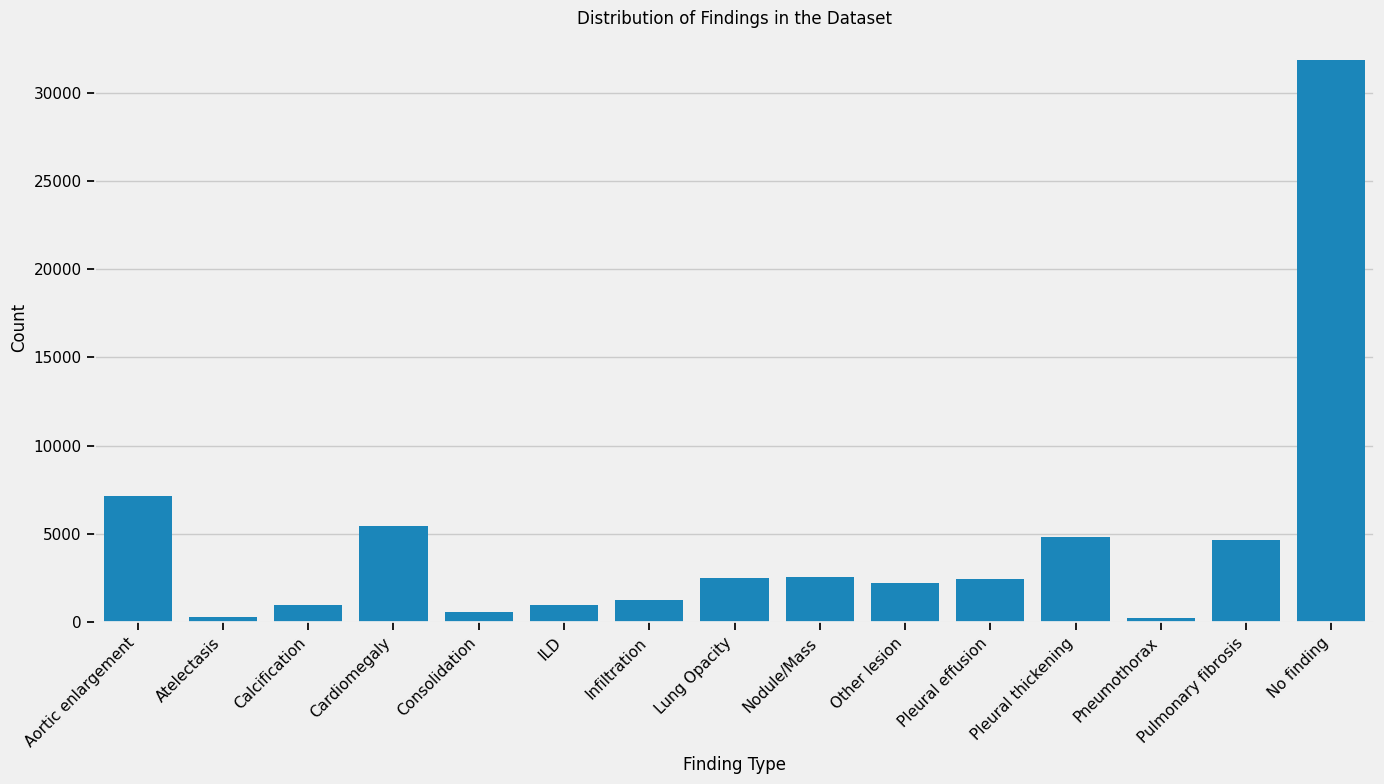

In [5]:
plt.figure(figsize=(14, 8))
ax = sns.barplot(x=named_distribution.index, y=named_distribution.values)
ax.set_xticks(ax.get_xticks())  
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Distribution of Findings in the Dataset')
plt.ylabel('Count')
plt.xlabel('Finding Type')
plt.tight_layout()
plt.show()

### Class Distribution Analysis

The dataset exhibits extreme class imbalance with "No finding" dominating (48% of annotations). Critical conditions like Pneumothorax (226) and Atelectasis (279) are severely underrepresented. This requires:
- Specialized loss functions
- Targeted data augmentation
- Clinically-calibrated detection thresholds

#### Handling the `No finding` Class:

For object detection with YOLOv8:
- **Exclude this class** - Object detection typically focuses on identifying present abnormalities
- YOLOv8 naturally handles absence of detections without requiring explicit "normal" labels
- Including "No finding" would create empty bounding boxes, contradicting the detection paradigm

We'll proceed without the "No finding" class in our YOLO implementation, treating the absence of detections as the normal state, which is the standard approach in medical object detection.

In [6]:
finding_df = train_df[train_df['class_id'] != 14].copy()


finding_distribution = finding_df['class_id'].value_counts().sort_index()
named_finding_distribution = pd.Series({class_names[k]: v for k, v in finding_distribution.items()}, 
                                      name='count')

named_finding_distribution

Aortic enlargement    7162
Atelectasis            279
Calcification          960
Cardiomegaly          5427
Consolidation          556
ILD                   1000
Infiltration          1247
Lung Opacity          2483
Nodule/Mass           2580
Other lesion          2203
Pleural effusion      2476
Pleural thickening    4842
Pneumothorax           226
Pulmonary fibrosis    4655
Name: count, dtype: int64

## Bounding Box Analysis

Understanding the characteristics of bounding boxes helps us optimize our detection model. Let's examine the size, aspect ratio, and position of annotations across different findings.

In [7]:
finding_df['width'] = finding_df['x_max'] - finding_df['x_min']
finding_df['height'] = finding_df['y_max'] - finding_df['y_min']
finding_df['area'] = finding_df['width'] * finding_df['height']
finding_df['aspect_ratio'] = finding_df['width'] / finding_df['height']

### Bounding Box Size

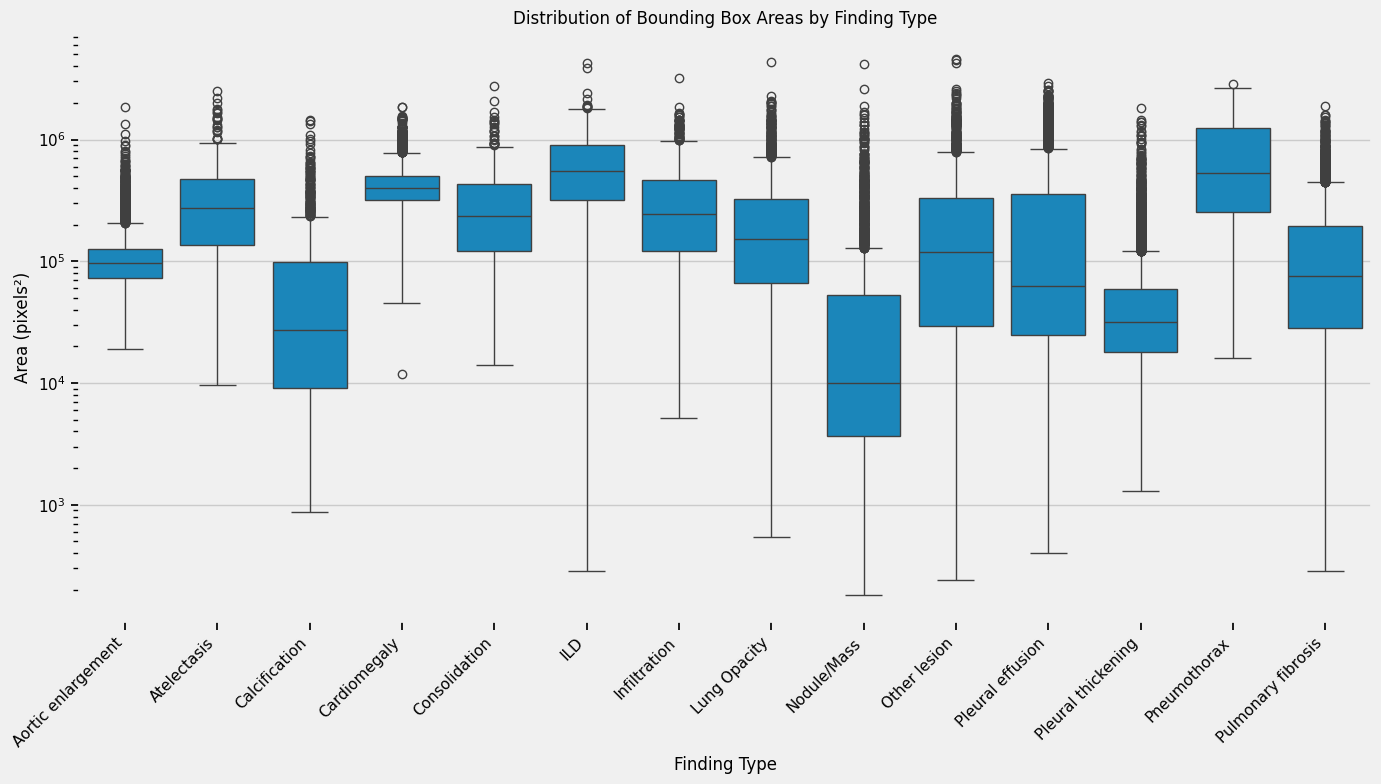

In [8]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='class_id', y='area', data=finding_df)
plt.xticks(range(14), [class_names[i] for i in range(14)], rotation=45, ha='right')
plt.title('Distribution of Bounding Box Areas by Finding Type')
plt.ylabel('Area (pixels²)')
plt.xlabel('Finding Type')
plt.yscale('log') 
plt.tight_layout()
plt.show()

### Bounding Box Size Analysis

Findings show considerable size variation (10³ to 10⁶ pixels²) with distinct patterns - Pneumothorax presents largest areas while Nodule/Mass findings are smallest. Implementation needs:
- Multi-scale detection capabilities
- Optimized anchor boxes
- Finding-specific augmentation strategies

### Spatial Distribution 

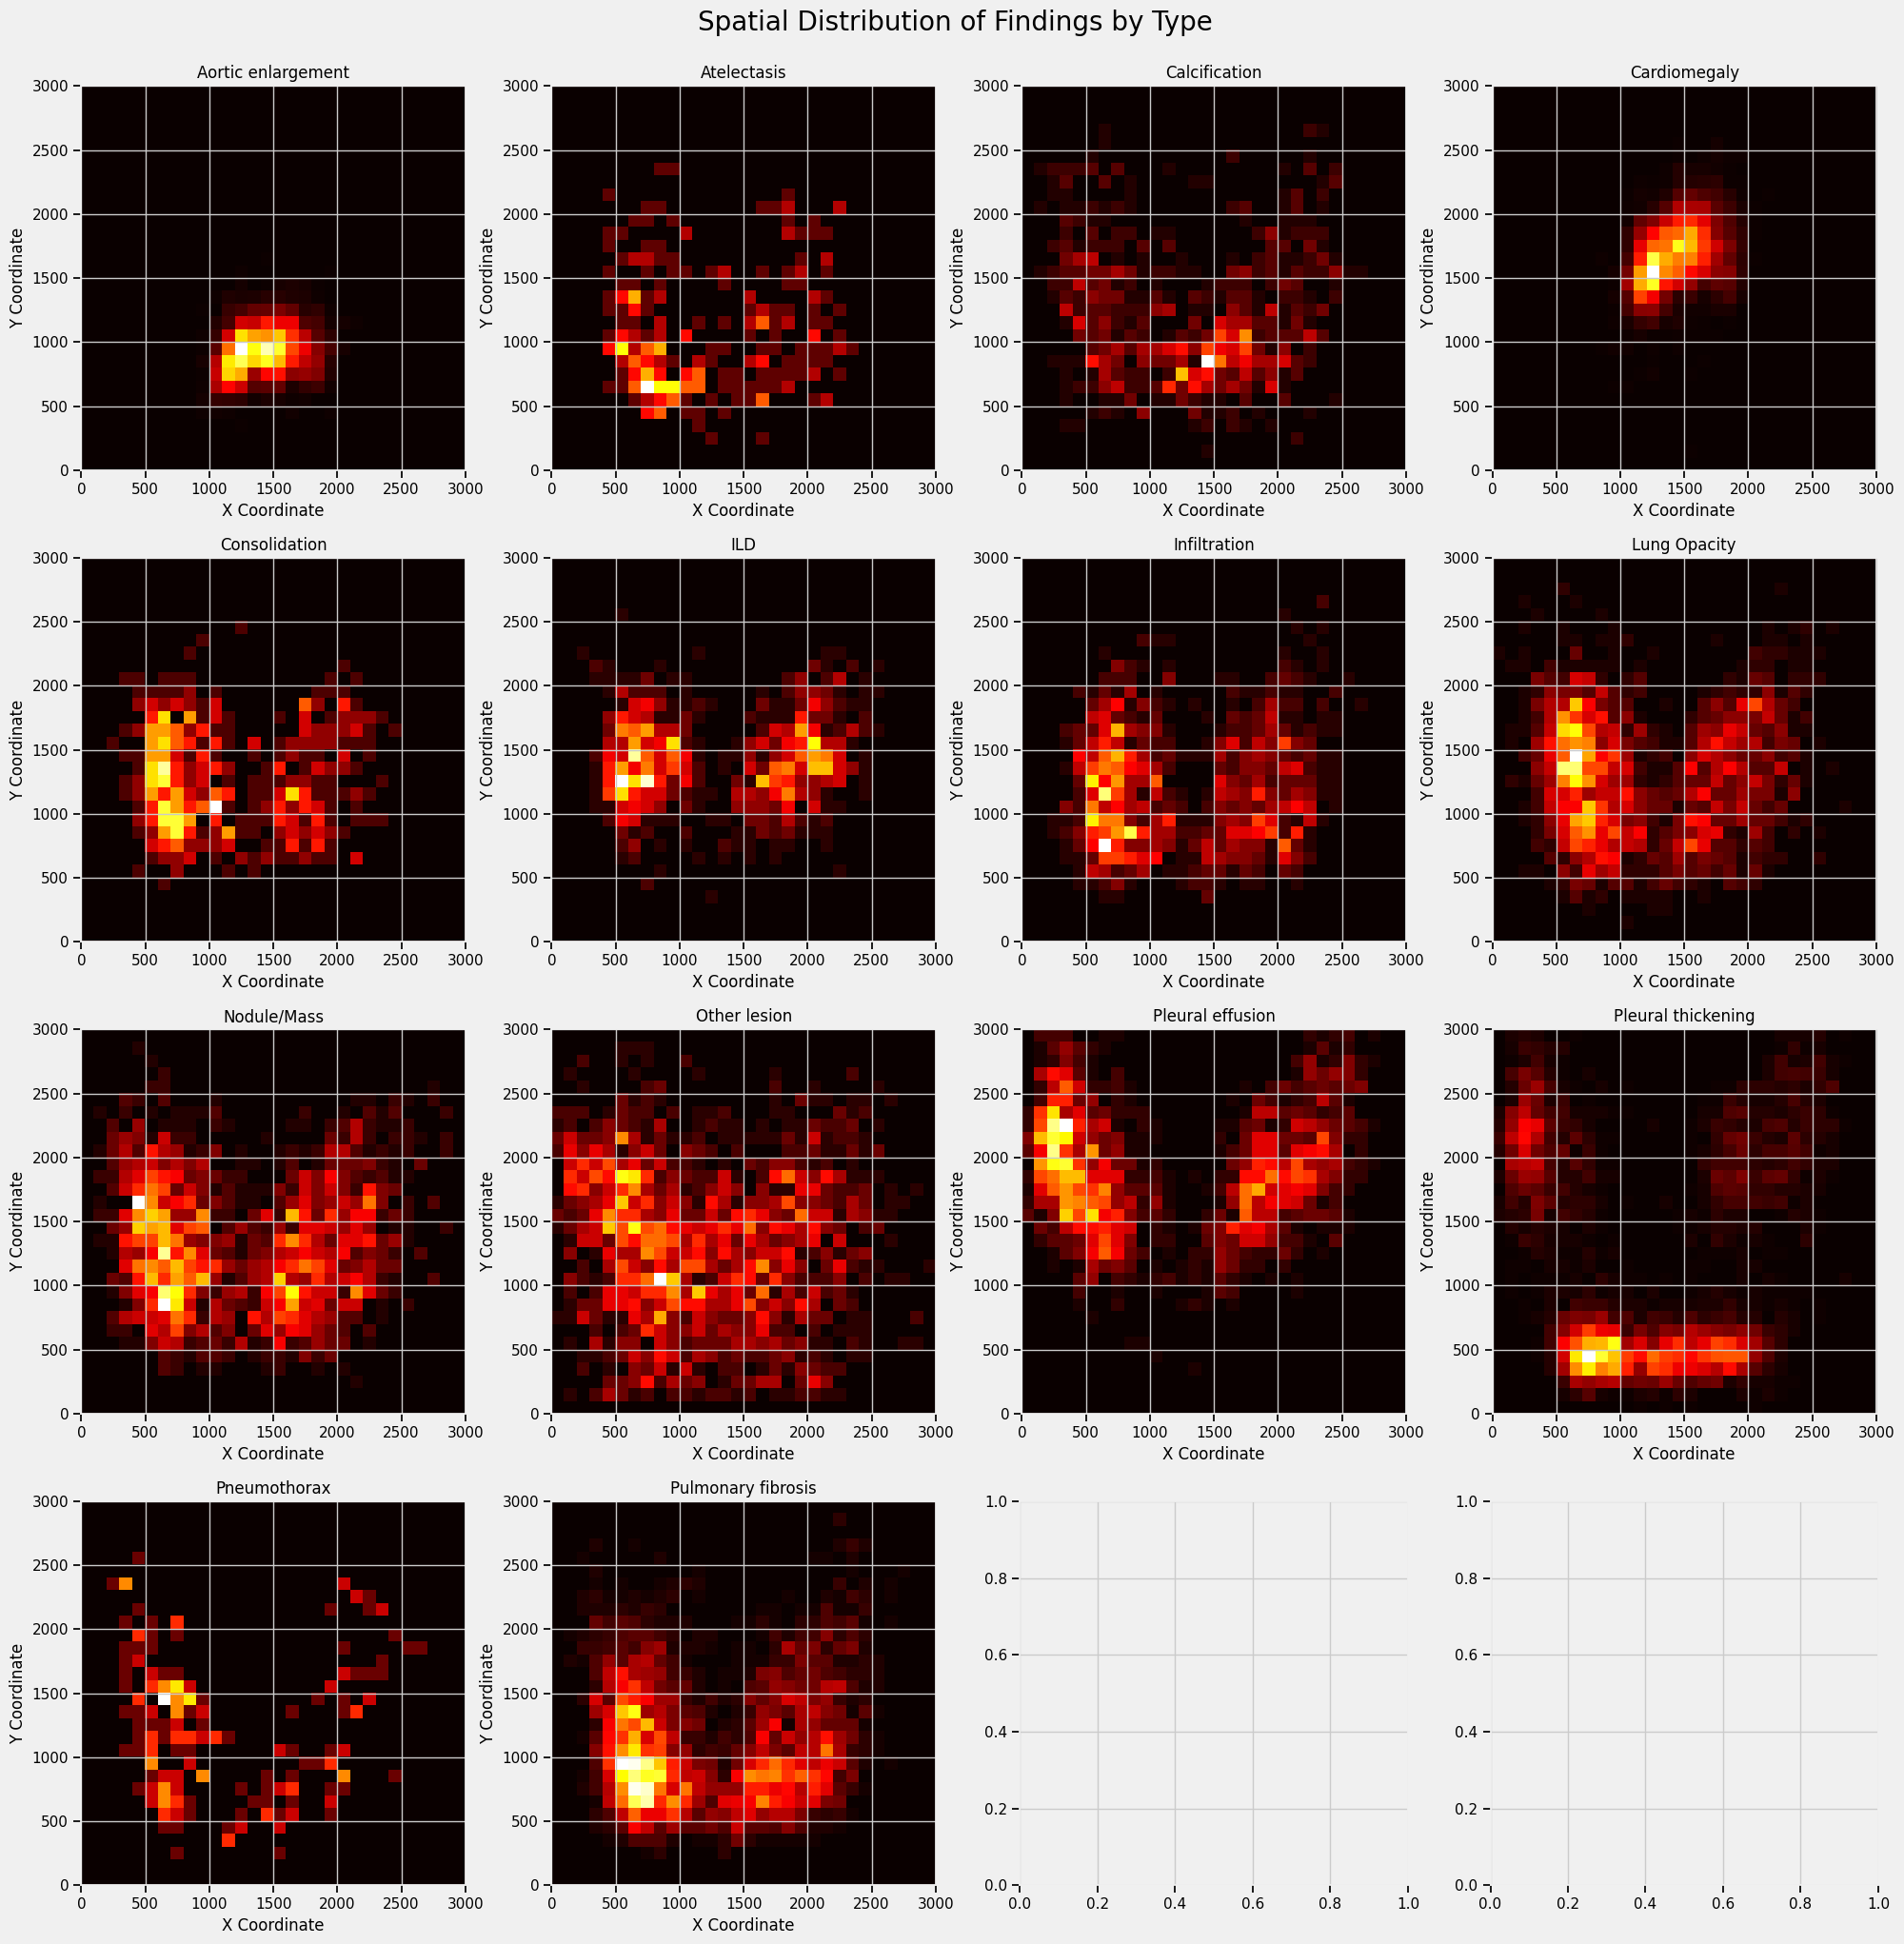

In [9]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
axs = axs.flatten()

for i, class_id in enumerate(range(14)):
    class_data = finding_df[finding_df['class_id'] == class_id]
    if len(class_data) > 0:
        x = (class_data['x_min'] + class_data['x_max']) / 2
        y = (class_data['y_min'] + class_data['y_max']) / 2
        
        heatmap, xedges, yedges = np.histogram2d(x, y, bins=30, range=[[0, 3000], [0, 3000]])
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        
        axs[i].imshow(heatmap.T, extent=extent, origin='lower', cmap='hot', interpolation='nearest')
        axs[i].set_title(class_names[class_id])
        axs[i].set_xlabel('X Coordinate')
        axs[i].set_ylabel('Y Coordinate')
        
    elif i < 14:  
        axs[i].set_title(f"{class_names[class_id]} (No Data)")
        
    if i >= 14:
        fig.delaxes(axs[i])

plt.tight_layout()
plt.suptitle('Spatial Distribution of Findings by Type', fontsize=20, y=1.02)
plt.show()

### Spatial Distribution 

The heatmap visualization reveals distinct anatomical patterns that align with clinical knowledge:

- **Aortic enlargement**: Concentrated in the upper central chest, corresponding to the aortic arch location
- **Cardiomegaly**: Focused in the middle left hemithorax, representing the cardiac silhouette 
- **Pleural thickening**: Concentrated along the lateral and basal aspects of the lung fields
- **Pleural effusion**: Localized to the lateral and lower lung zones, where fluid typically accumulates
- **Lung Opacity** and **Consolidation**: Dispersed throughout the lung fields with bilateral distribution
- **Pneumothorax**: Shows distinctive peripheral pattern along the lateral aspects of the lung

These spatial patterns provide valuable insights for model development:
- Anatomical location is a strong feature for differentiating between findings
- Some conditions have highly predictable locations while others are more diffuse
- The model should leverage spatial context while maintaining flexibility for atypical presentations

## Image Visualization

Let's examine some actual X-ray images with their corresponding annotations to understand how findings appear visually and verify the bounding box annotations.

### Image Visualization Function

Creating a function to display X-ray images with their corresponding bounding box annotations.

In [10]:
train_images_path = data_path / 'train_images'

def visualize_image_with_annotations(image_id, df):
    image_path = os.path.join(train_images_path, f"{image_id}.dicom")
    
    if not os.path.exists(image_path):
        print(f"Image {image_id}.dicom not found. Please download it to {train_images_path}")
        return

    
    dicom = pydicom.dcmread(image_path)

    image = dicom.pixel_array.astype(float)
    image = (image - image.min()) / (image.max() - image.min()) * 255.0
    image = image.astype(np.uint8)

    plt.figure(figsize=(8, 6))

    plt.imshow(image, cmap='gray')

    image_annotations = df[df['image_id'] == image_id]
    
    # Add bounding boxes and labels
    for _, annotation in image_annotations.iterrows():
        x_min, y_min = annotation['x_min'], annotation['y_min']
        x_max, y_max = annotation['x_max'], annotation['y_max']
        class_id = annotation['class_id']

        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                            fill=False, edgecolor='red', linewidth=1.5)  
        plt.gca().add_patch(rect)
  
        plt.text(x_min, y_min - 5, class_names[class_id], 
                color='white', fontsize=9, backgroundcolor='red')
    
    plt.title(f"Image ID: {image_id}", fontsize=10)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

### Available Images Analysis

Checking which images are available in our dataset and which findings they contain.

In [11]:
def analyze_available_images():
    available_images = [f[:-6] for f in os.listdir(train_images_path) 
                      if f.endswith('.dicom')]
    
    if not available_images:
        print("No images found in the directory. Please download some sample images.")
        return []
    
    print(f"Found {len(available_images)} images in {train_images_path}")
    
    findings_df = finding_df[finding_df['image_id'].isin(available_images)]
    
    if findings_df.empty:
        print("No annotations found for the available images.")
        return available_images
    
    class_counts = findings_df['class_id'].value_counts().sort_index()
    
    print("\nFindings in available images:")
    for class_id, count in class_counts.items():
        print(f"- {class_names[class_id]}: {count} instances")
    
    available_classes = set(class_counts.index)
    missing_classes = set(range(14)) - available_classes
    
    if missing_classes:
        print("\nMissing findings in available images:")
        for c in missing_classes:
            print(f"- {class_names[c]}")
    
    return available_images

### Sample Image Visualization

Let's visualize a few sample images with their annotations to understand the data.

Found 500 images in ..\data\raw\train_images

Findings in available images:
- Aortic enlargement: 625 instances
- Atelectasis: 102 instances
- Calcification: 196 instances
- Cardiomegaly: 435 instances
- Consolidation: 172 instances
- ILD: 212 instances
- Infiltration: 264 instances
- Lung Opacity: 464 instances
- Nodule/Mass: 387 instances
- Other lesion: 437 instances
- Pleural effusion: 462 instances
- Pleural thickening: 753 instances
- Pneumothorax: 112 instances
- Pulmonary fibrosis: 759 instances

Randomly selected 3 images for visualization

Visualizing image: da0364cb98ded8ccbdea0d70fc8fa38c
Findings: ['Pleural thickening', 'Pleural effusion', 'Cardiomegaly', 'Pulmonary fibrosis', 'Aortic enlargement', 'Atelectasis', 'Lung Opacity']


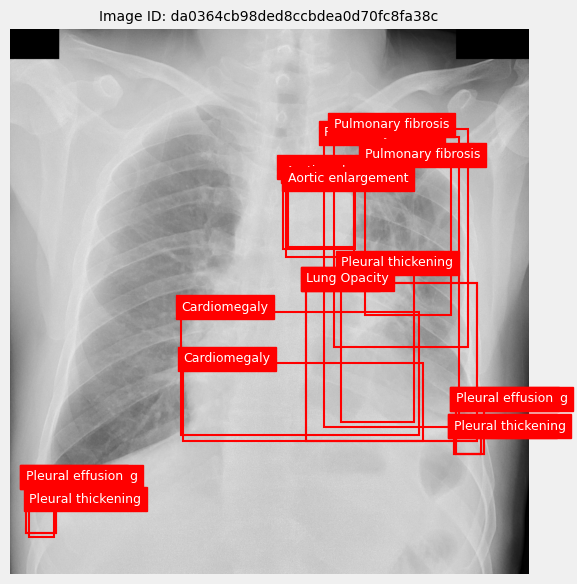


Visualizing image: 15b164c54f0bf0baac308b47a45a1468
Findings: ['Infiltration', 'Consolidation', 'Cardiomegaly', 'Lung Opacity', 'Other lesion', 'Aortic enlargement', 'Pulmonary fibrosis']


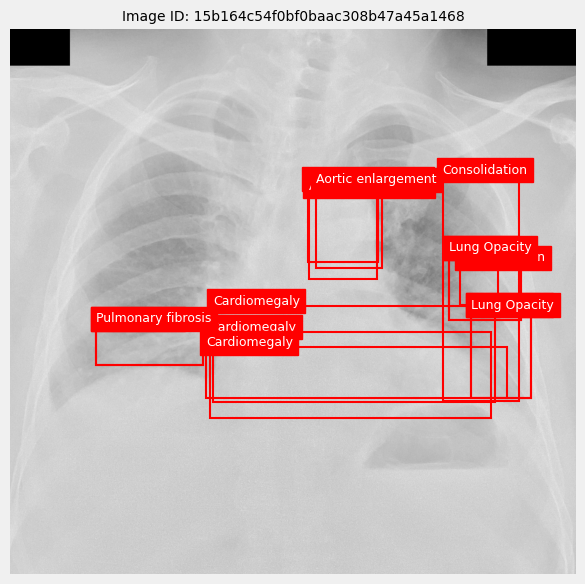


Visualizing image: 54f9194379210945be0ed72fac357456
Findings: ['Atelectasis', 'Lung Opacity', 'Pleural thickening', 'Infiltration', 'Pneumothorax', 'Pleural effusion', 'Other lesion', 'Consolidation', 'Cardiomegaly']


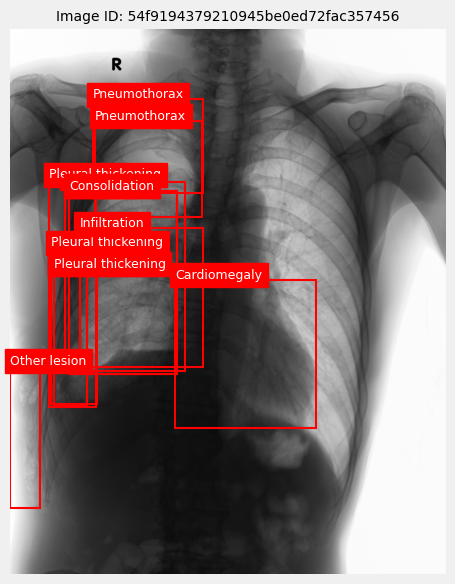

In [12]:
available_images = analyze_available_images()

if available_images:
    num_samples = min(3, len(available_images))
    samples = random.sample(available_images, num_samples)
    
    print(f"\nRandomly selected {num_samples} images for visualization")
    
    for img_id in samples:
        print(f"\nVisualizing image: {img_id}")
        image_findings = finding_df[finding_df['image_id'] == img_id]['class_id'].unique()
        print(f"Findings: {[class_names[c] for c in image_findings]}")
        visualize_image_with_annotations(img_id, finding_df)
else:
    print("No images available for visualization.")

## YOLO Format Conversion

YOLOv8 requires a specific format for annotations:
- One text file per image with the same name as the image
- Each line in the text file representing one object: `class_id center_x center_y width height`
- All values normalized to the range [0, 1]
- Class IDs starting from 0

Let's create a function to convert our VinBigData annotations to YOLO format.

In [13]:
def convert_to_yolo_format(img_id, annotations_df, output_dir, img_width=None, img_height=None):
    """
    Convert bounding box annotations to YOLO format for a single image
    """
    img_annotations = annotations_df[annotations_df['image_id'] == img_id]
    
    if img_annotations.empty:
        return
    
    # If dimensions not provided, read from DICOM
    if img_width is None or img_height is None:
        dicom_path = os.path.join(train_images_path, f"{img_id}.dicom")
        if not os.path.exists(dicom_path):
            print(f"Error: Image {img_id}.dicom not found")
            return
            
        try:
            dicom = pydicom.dcmread(dicom_path)
            img_height, img_width = dicom.pixel_array.shape
        except Exception as e:
            print(f"Error reading DICOM dimensions: {e}")
            return
    
    os.makedirs(output_dir, exist_ok=True)

    output_file = os.path.join(output_dir, f"{img_id}.txt")
    
    with open(output_file, 'w') as f:
        for _, row in img_annotations.iterrows():
            x_min, y_min = row['x_min'], row['y_min']
            x_max, y_max = row['x_max'], row['y_max']
            class_id = row['class_id']
            
            # YOLO format requires normalized center coordinates and dimensions
            x_center = ((x_min + x_max) / 2) / img_width
            y_center = ((y_min + y_max) / 2) / img_height
            width = (x_max - x_min) / img_width
            height = (y_max - y_min) / img_height
            
            # Ensure values are in range [0, 1]
            x_center = max(0, min(x_center, 1))
            y_center = max(0, min(y_center, 1))
            width = max(0, min(width, 1))
            height = max(0, min(height, 1))
            
            
            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

## Creating Dataset Structure for YOLO

YOLOv8 expects a specific directory structure for training. Let's set up train and validation splits.

In [14]:
def prepare_yolo_dataset(df, images, output_base_dir, train_ratio=0.8):
    """
    Prepare YOLO dataset structure with train/val splits
    """
    
    # Create directories
    train_dir = os.path.join(output_base_dir, 'train')
    val_dir = os.path.join(output_base_dir, 'val')
    train_labels_dir = os.path.join(train_dir, 'labels')
    val_labels_dir = os.path.join(val_dir, 'labels')
    train_images_dir = os.path.join(train_dir, 'images')
    val_images_dir = os.path.join(val_dir, 'images')
    
    os.makedirs(train_labels_dir, exist_ok=True)
    os.makedirs(val_labels_dir, exist_ok=True)
    os.makedirs(train_images_dir, exist_ok=True)
    os.makedirs(val_images_dir, exist_ok=True)
    
    # Shuffle and split images into train and validation sets
    images_copy = images.copy()
    random.shuffle(images_copy)
    split_idx = int(len(images_copy) * train_ratio)
    train_images = images_copy[:split_idx]
    val_images = images_copy[split_idx:]
    
    print(f"Processing {len(train_images)} training images and {len(val_images)} validation images")
    
    # Convert annotations to YOLO format
    for img_id in train_images:
        convert_to_yolo_format(img_id, df, train_labels_dir)
        
    for img_id in val_images:
        convert_to_yolo_format(img_id, df, val_labels_dir)
    
    # Create data.yaml configuration file
    data_yaml = {
        'train': './train/images',
        'val': './val/images',
        'nc': 14,  
        'names': [class_names[i] for i in range(14)] 
    }
    
    with open(os.path.join(output_base_dir, 'data.yaml'), 'w') as f:
        yaml.dump(data_yaml, f, default_flow_style=False)
    
    print(f"Created YOLO dataset structure in {output_base_dir}")
    print(f"Created data.yaml with class information")
    
    return train_images, val_images

## Converting DICOM to PNG for YOLO

YOLOv8 works best with standard image formats like PNG. Let's convert our DICOM files to PNG.

In [15]:
def convert_dicom_to_png(img_id, src_dir, dest_dir):
    dicom_path = os.path.join(src_dir, f"{img_id}.dicom")
    png_path = os.path.join(dest_dir, f"{img_id}.png")
    
    try:
        dicom = pydicom.dcmread(dicom_path)
        
        # Convert to float and normalize to 0-255
        image = dicom.pixel_array.astype(float)
        image = (image - image.min()) / (image.max() - image.min()) * 255.0
        image = image.astype(np.uint8)
        
        cv2.imwrite(png_path, image)
        return True
    except Exception as e:
        print(f"Error converting {img_id}: {e}")
        return False

In [20]:
project_root = Path('../')
processed_data_dir = os.path.join(project_root, 'data', 'processed', 'yolo_dataset')
print("Preparing YOLO dataset...")

train_images, val_images = prepare_yolo_dataset(finding_df, available_images, processed_data_dir)
print("\nConverting DICOM images to PNG format...")

total_images = len(train_images) + len(val_images)
converted_count = 0

train_images_dir = os.path.join(processed_data_dir, 'train', 'images')
for img_id in train_images:
    if convert_dicom_to_png(img_id, train_images_path, train_images_dir):
        converted_count += 1
    if converted_count % 50 == 0:
        print(f"Converted {converted_count}/{total_images} images...")

val_images_dir = os.path.join(processed_data_dir, 'val', 'images')
for img_id in val_images:
    if convert_dicom_to_png(img_id, train_images_path, val_images_dir):
        converted_count += 1
    if converted_count % 50 == 0:
        print(f"Converted {converted_count}/{total_images} images...")

print(f"\nConverted {converted_count}/{total_images} images successfully!")
print("\nDataset preparation complete! The data is now ready for YOLOv8 training.")

Preparing YOLO dataset...
Processing 400 training images and 100 validation images
Created YOLO dataset structure in ..\data\processed\yolo_dataset
Created data.yaml with class information

Converting DICOM images to PNG format...
Converted 50/500 images...
Converted 100/500 images...
Converted 150/500 images...
Converted 200/500 images...
Converted 250/500 images...
Converted 300/500 images...
Converted 350/500 images...
Converted 400/500 images...
Converted 450/500 images...
Converted 500/500 images...

Converted 500/500 images successfully!

Dataset preparation complete! The data is now ready for YOLOv8 training.


## Sample Verification of YOLO Format

Let's verify a few samples to ensure our conversion was successful.


Verifying sample: c394eadea89e5795c8037280492d116d
Files exist. Displaying image with YOLO annotations...


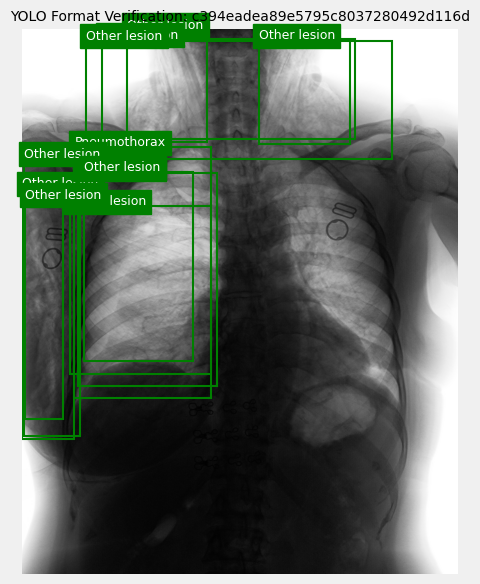

YOLO annotation content (11 objects):
  Object 1: Class Other lesion, center=(0.059462, 0.522049), size=(0.118924, 0.461458)
  Object 2: Class Other lesion, center=(0.332899, 0.103819), size=(0.183160, 0.205556)
  Object 3: Class Other lesion, center=(0.271267, 0.478993), size=(0.324653, 0.307986)
  Object 4: Class Other lesion, center=(0.648220, 0.115451), size=(0.210503, 0.189931)
  Object 5: Class Other lesion, center=(0.473524, 0.109896), size=(0.580729, 0.182292)
  Object 6: Class Lung Opacity, center=(0.287977, 0.459201), size=(0.319010, 0.390625)
  Object 7: Class Other lesion, center=(0.050564, 0.514062), size=(0.086372, 0.401736)
  Object 8: Class Other lesion, center=(0.496745, 0.129861), size=(0.701823, 0.217361)
  Object 9: Class Pneumothorax, center=(0.276693, 0.447222), size=(0.314670, 0.461111)
  Object 10: Class Other lesion, center=(0.069227, 0.492188), size=(0.128906, 0.509375)
  Object 11: Class Other lesion, center=(0.266927, 0.435764), size=(0.249132, 0.346528)

Ve

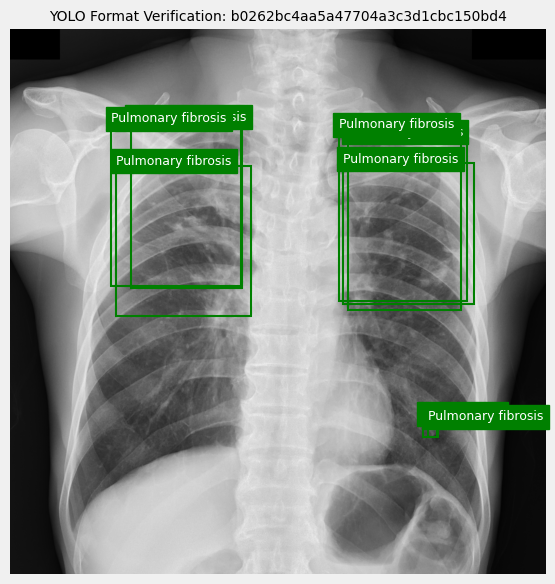

YOLO annotation content (8 objects):
  Object 1: Class Nodule/Mass, center=(0.785640, 0.731331), size=(0.028996, 0.033605)
  Object 2: Class Pulmonary fibrosis, center=(0.743183, 0.374915), size=(0.244391, 0.256959)
  Object 3: Class Pulmonary fibrosis, center=(0.735589, 0.356415), size=(0.211253, 0.317719)
  Object 4: Class Pulmonary fibrosis, center=(0.329651, 0.322301), size=(0.208492, 0.304481)
  Object 5: Class Pulmonary fibrosis, center=(0.733690, 0.341141), size=(0.239903, 0.315682)
  Object 6: Class Pulmonary fibrosis, center=(0.324646, 0.387984), size=(0.252330, 0.275628)
  Object 7: Class Pulmonary fibrosis, center=(0.788574, 0.734046), size=(0.016914, 0.028174)
  Object 8: Class Pulmonary fibrosis, center=(0.309631, 0.322301), size=(0.241629, 0.299728)


In [21]:
def verify_yolo_conversion(sample_count=3):
    """
    Verify a few random samples to ensure YOLO conversion was successful
    """

    samples = random.sample(train_images, min(sample_count, len(train_images)))
    
    for img_id in samples:
        print(f"\nVerifying sample: {img_id}")
        png_path = os.path.join(processed_data_dir, 'train', 'images', f"{img_id}.png")
        anno_path = os.path.join(processed_data_dir, 'train', 'labels', f"{img_id}.txt")
        
        if not os.path.exists(png_path):
            print(f"Error: PNG image not found at {png_path}")
            continue
            
        if not os.path.exists(anno_path):
            print(f"Error: YOLO annotation not found at {anno_path}")
            continue
            
        print("Files exist. Displaying image with YOLO annotations...")

        image = cv2.imread(png_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height, width = image.shape[:2]

        with open(anno_path, 'r') as f:
            lines = f.readlines()

        plt.figure(figsize=(8, 6))
        plt.imshow(image, cmap='gray')

        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center = float(parts[1]) * width
            y_center = float(parts[2]) * height
            bbox_width = float(parts[3]) * width
            bbox_height = float(parts[4]) * height
            
            # Convert center coordinates to top-left and bottom-right
            x_min = int(x_center - (bbox_width / 2))
            y_min = int(y_center - (bbox_height / 2))
            x_max = int(x_center + (bbox_width / 2))
            y_max = int(y_center + (bbox_height / 2))
            

            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                fill=False, edgecolor='green', linewidth=1.5)
            plt.gca().add_patch(rect)
            

            plt.text(x_min, y_min - 5, class_names[class_id], 
                    color='white', fontsize=9, backgroundcolor='green')
        
        plt.title(f"YOLO Format Verification: {img_id}", fontsize=10)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        

        print(f"YOLO annotation content ({len(lines)} objects):")
        for i, line in enumerate(lines):
            parts = line.strip().split()
            print(f"  Object {i+1}: Class {class_names[int(parts[0])]}, "
                  f"center=({parts[1]}, {parts[2]}), size=({parts[3]}, {parts[4]})")


verify_yolo_conversion(sample_count=2)

## Summary

In this notebook, we have:

1. Explored the VinBigData Chest X-ray dataset
2. Analyzed the distribution of different medical findings
3. Visualized sample X-ray images with their bounding box annotations
4. Converted the dataset to YOLO format for training:
   - Split data into training and validation sets
   - Converted annotations to YOLO format
   - Converted DICOM images to PNG format
   - Created the necessary directory structure
   - Generated the data.yaml configuration file

The data is now ready for training a YOLOv8 model in the next notebook.